In [13]:
import datetime
import gc
import numpy as np
import os
import operator
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler
!pip install lightgbm
import lightgbm as lgb
!pip install xgboost
import xgboost as xgb

In [14]:
#I want to get an idea for what the data looks like, so I will visualize a little bit of it and then also 
#check to see the shape of it
train_df = pd.read_csv('train.csv')
train_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [15]:
test_df = pd.read_csv('test.csv')

In [17]:
test_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [16]:
print("Costa Rican Household Poverty Level Prediction -  rows:",train_df.shape[0]," columns:", train_df.shape[1])
print("Costa Rican Household Poverty Level Prediction -  rows:",test_df.shape[0]," columns:", test_df.shape[1])

Costa Rican Household Poverty Level Prediction -  rows: 9557  columns: 143
Costa Rican Household Poverty Level Prediction -  rows: 23856  columns: 142


In [18]:
#Now That I have an idea for how big the data is, I need to see if there are any missing values to account for
#in either of the data sets
train_df.isnull().values.any()

True

In [19]:
test_df.isnull().values.any()

True

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [29]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


In [26]:
train_df.isnull().values.sum(axis=0)

array([   0, 6860,    0,    0,    0,    0,    0,    0, 7342,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 7928,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    5,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    5,    0,    0])

In [27]:
test_df.isnull().values.sum(axis=0)

array([    0, 17403,     0,     0,     0,     0,     0,     0, 18126,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0, 19653,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,    31,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [24]:
train_df_describe = train_df.describe()
train_df_describe

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,1.036574,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
50%,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
75%,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000
max,2.353477e+06,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,8.000000,...,441.000000,9409.000000,169.000000,441.000000,81.000000,36.000000,64.000000,1369.000000,9409.000000,4.000000


In [25]:
test_df_describe = test_df.describe()
test_df_describe

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
count,6.453000e+03,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,5730.000000,23856.000000,23856.000000,...,23856.000000,23856.00000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23825.000000,23856.000000
mean,1.748726e+05,0.050679,4.955776,0.028421,0.992748,0.961603,0.240191,1.348517,0.416541,1.563967,...,34.454183,74.44974,1657.798080,19.113389,54.087232,3.885480,3.564751,4.171669,100.509220,1657.798080
std,1.567887e+05,0.219346,1.539753,0.166174,0.084850,0.192157,0.427208,0.694216,0.713255,0.990171,...,21.696245,76.99701,1753.603406,17.314597,77.312255,6.878967,6.668757,13.105989,89.211063,1753.603406
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000
25%,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,16.000000,16.00000,256.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,256.000000
50%,1.400000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,32.000000,36.00000,1024.000000,16.000000,36.000000,1.000000,2.250000,0.444444,75.111115,1024.000000
75%,2.200000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,1.750000,1.000000,2.000000,...,51.000000,121.00000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,132.250000,2601.000000
max,2.852700e+06,1.000000,15.000000,1.000000,1.000000,1.000000,1.000000,6.000000,6.000000,7.000000,...,97.000000,441.00000,9409.000000,169.000000,441.000000,100.000000,169.000000,64.000000,1296.000000,9409.000000


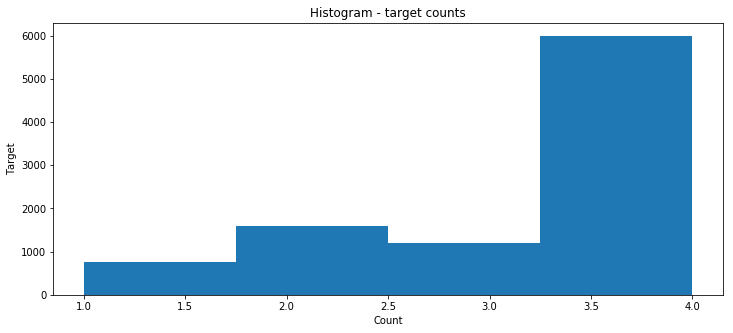

In [30]:
#Now that I can see how much of the data is missing,and which variables have the least amount of missing data,
#I am going to look at the target variable, its distribution, and what other variables will be good to use
#in the model

plt.figure(figsize=(12, 5))
plt.hist(train_df.Target.values, bins=4)
plt.title('Histogram - target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

C:\Users\karla\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


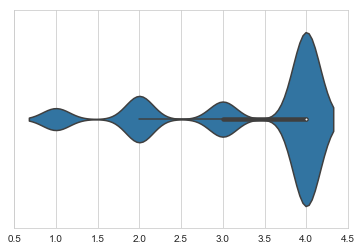

In [31]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=train_df.Target.values)
plt.show()

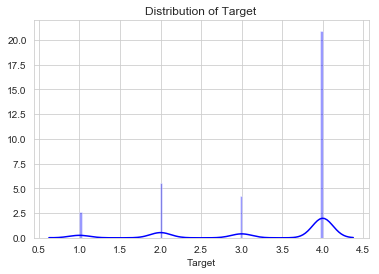

In [32]:
plt.title("Distribution of Target")
sns.distplot(train_df['Target'].dropna(),color='blue', kde=True,bins=100)
plt.show()

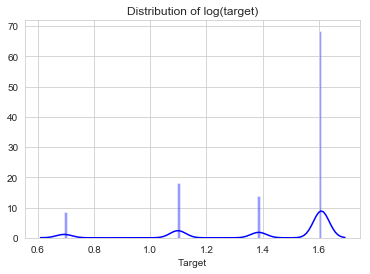

In [33]:
plt.title("Distribution of log(target)")
sns.distplot(np.log1p(train_df['Target']).dropna(),color='blue', kde=True,bins=100)
plt.show()

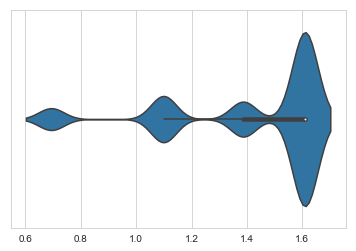

In [34]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=np.log(1+train_df.Target.values))
plt.show()

In [36]:
np.unique(train_df.Target.values)

array([1, 2, 3, 4], dtype=int64)

In [37]:
columns_to_use = train_df.columns[1:-1]
columns_to_use

Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4h1', 'r4h2',
       ...
       'age', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe',
       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
       'agesq'],
      dtype='object', length=141)

In [38]:
y = train_df['Target'].values-1
train_test_df = pd.concat([train_df[columns_to_use], test_df[columns_to_use]], axis=0)
object_cols = [f_ for f_ in train_test_df.columns if train_test_df[f_].dtype == 'object']

In [39]:
#Now I need to add labels to the dataframes I'll be using
for col in object_cols:
    le = LabelEncoder()
    print(col)
    le.fit(train_test_df[col].astype(str))
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
del le

idhogar
dependency
edjefe
edjefa


In [40]:
def dprint(*args, **kwargs):
    print("[{}] ".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")) + \
        " ".join(map(str,args)), **kwargs)

id_name = 'Id'
target_name = 'Target'

df_all = pd.concat([train_df, test_df], axis=0)
cols = [f_ for f_ in df_all.columns if df_all[f_].dtype == 'object' and f_ != id_name]
print(cols)

for c in tqdm(cols):
    le = preprocessing.LabelEncoder()
    le.fit(df_all[c].astype(str))
    train_df[c] = le.transform(train_df[c].astype(str))
    test_df[c] = le.transform(test[c].astype(str))
    
    del le
gc.collect()

def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms']

extract_features(train_df)
extract_features(test_df)

C:\Users\karla\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


[]


0it [00:00, ?it/s]


C:\Users\karla\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\karla\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


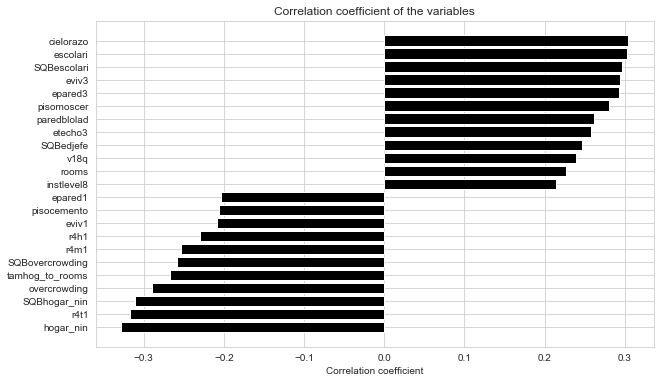

In [41]:
#Now to try and identify which variables are highly correlated with the target variable

labels = []
values = []
for col in train_df.columns:
    if col not in ["Id", "Target"]:
        labels.append(col)
        values.append(np.corrcoef(train_df[col].values, train_df["Target"].values)[0,1])
corr_df = pd.DataFrame({'columns_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.20) | (corr_df['corr_values']<-0.20)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,6))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='black')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.columns_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

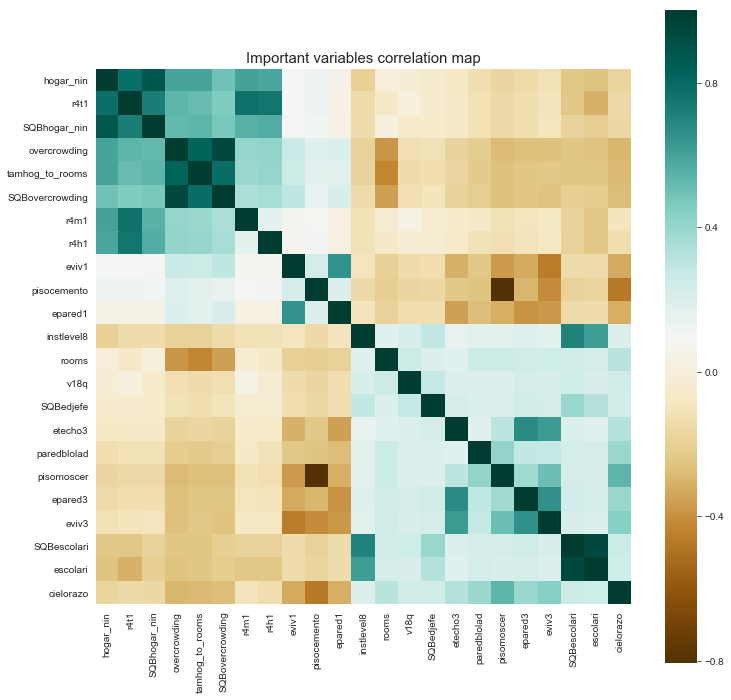

In [42]:
#Now to make the dataframe with the most highly correlated variables

temp_df = train_df[corr_df.columns_labels.tolist()]
corrmat = temp_df.corr(method='pearson')
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=1., square=True, cmap=plt.cm.BrBG)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [43]:
#Finally, with all the data cleaned and sorted, I can get to work constructing the model I will use to
#make the predictions

cnt = 0
p_buf = []
n_splits = 20
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=None)
err_buf = []   

cols_to_drop = [
    id_name, 
    target_name,
]
X = train_df.drop(cols_to_drop, axis=1, errors='ignore')
feature_names = list(X.columns)
X = X.fillna(0)
X = X.values
y = train_df[target_name].values

classes = np.unique(y)
dprint('Number of classes: {}'.format(len(classes)))
c2i = {}
i2c = {}
for i, c in enumerate(classes):
    c2i[c] = i
    i2c[i] = c

y_le = np.array([c2i[c] for c in y])

X_test = test_df.drop(cols_to_drop, axis=1, errors='ignore')
X_test = X_test.fillna(0)
X_test = X_test.values
id_test = test_df[id_name].values

dprint(X.shape, y.shape)
dprint(X_test.shape)

n_features = X.shape[1]

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'max_depth': -1,
    'num_leaves': 14,
    'learning_rate': 0.1,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': 8,
    'colsample_bytree': 0.89,
    'min_child_samples': 90,
    'subsample': 0.96,
    'lambda_l2': 1.0,
    'min_gain_to_split': 0,
    'num_class': len(np.unique(y)),
}

[2019-03-21 12:29] Number of classes: 4
[2019-03-21 12:29] (9557, 144) (9557,)
[2019-03-21 12:29] (23856, 144)


In [45]:
sampler = RandomUnderSampler(random_state=314)
X, y = sampler.fit_sample(X, y)
y_le = np.array([c2i[c] for c in y])

for train_index, valid_index in kf.split(X, y):
    print('Fold {}/{}*{}'.format(cnt + 1, n_splits, n_repeats))
    params = lgb_params.copy() 

    lgb_train = lgb.Dataset(
        X[train_index], 
        y_le[train_index], 
        feature_name=feature_names,
        )
    lgb_train.raw_data = None

    lgb_valid = lgb.Dataset(
        X[valid_index], 
        y_le[valid_index],
        feature_name=feature_names,
        )
    lgb_valid.raw_data = None

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=99999,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=400, 
        verbose_eval=100, 
    )

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(10):
            if i < len(tuples):
                print(i, tuples[i])
            else:
                break

        del importance, model_fnames, tuples

    p = model.predict(X[valid_index], num_iteration=model.best_iteration)

    err = f1_score(y_le[valid_index], np.argmax(p, axis=1), average='macro')

    dprint('{} F1: {}'.format(cnt + 1, err))

    p = model.predict(X_test, num_iteration=model.best_iteration)
    if len(p_buf) == 0:
        p_buf = np.array(p, dtype=np.float16)
    else:
        p_buf += np.array(p, dtype=np.float16)
    err_buf.append(err)

    cnt += 1

    del model, lgb_train, lgb_valid, p
    gc.collect

Fold 1/20*1
Training until validation scores don't improve for 400 rounds.
[100]	training's multi_logloss: 0.609591	valid_1's multi_logloss: 0.838159
[200]	training's multi_logloss: 0.386498	valid_1's multi_logloss: 0.685091
[300]	training's multi_logloss: 0.256749	valid_1's multi_logloss: 0.602375
[400]	training's multi_logloss: 0.177686	valid_1's multi_logloss: 0.543001
[500]	training's multi_logloss: 0.124466	valid_1's multi_logloss: 0.509126
[600]	training's multi_logloss: 0.0887673	valid_1's multi_logloss: 0.487977
[700]	training's multi_logloss: 0.0643016	valid_1's multi_logloss: 0.482994
[800]	training's multi_logloss: 0.0471919	valid_1's multi_logloss: 0.481731
[900]	training's multi_logloss: 0.0353012	valid_1's multi_logloss: 0.46946
[1000]	training's multi_logloss: 0.0266843	valid_1's multi_logloss: 0.473825
[1100]	training's multi_logloss: 0.0205119	valid_1's multi_logloss: 0.474024
[1200]	training's multi_logloss: 0.0160572	valid_1's multi_logloss: 0.481627
Early stopping, 

In [46]:
err_mean = np.mean(err_buf)
err_std = np.std(err_buf)
print('F1 = {:.6f} +/- {:.6f}'.format(err_mean, err_std))
preds = p_buf/cnt

F1 = 0.829088 +/- 0.029378


In [47]:
print(preds)
preds = np.argmax(preds, axis = 1) +1
preds

[[0.023    0.001176 0.00974  0.966   ]
 [0.02519  0.001173 0.00268  0.9697  ]
 [0.0394   0.001062 0.003674 0.9556  ]
 ...
 [0.003595 0.775    0.1167   0.1046  ]
 [0.006317 0.6104   0.1902   0.1921  ]
 [0.005585 0.4614   0.4106   0.1229  ]]


array([4, 4, 4, ..., 2, 2, 2], dtype=int64)

In [49]:
#Now to create the csv to upload to kaggle

sample_submission  = pd.read_csv("sample_submission.csv")
sample_submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [50]:
sample_submission['Target'] = preds
sample_submission.to_csv('submission_{:.6f}.csv'.format(err_mean), index=False)
sample_submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,3


In [ ]:
#After submitting my predictions, I got a score of .41043, which would be good enough for 220th on the leaderboard